# SCAT Trajectory Analysis with Weather Features
### End-to-End ML Pipeline: Data → Validation → Modeling
Includes:
- Weather-enhanced trajectories (`temp`, `wind_spd`, `wind_dir`)
- Train/Val/Test splits
- Visualization & Modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_dataset import load_splits
from plot_trajectory import plot_flight, plot_multiple_flights

In [2]:
# Paths
parquet_path = r"C:\Users\flyin\OneDrive\Documents\GitHub\dataset-research-SCAT\Machine Learning\validated_data\validated_cleaned.parquet"
split_dir = r"C:\Users\flyin\OneDrive\Documents\GitHub\dataset-research-SCAT\Machine Learning\validated_data"

# Load data
train_df, val_df, test_df = load_splits(parquet_path, split_dir)

# Print info
print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\nColumns in dataset:", list(train_df.columns))

Loading dataset from C:\Users\flyin\OneDrive\Documents\GitHub\dataset-research-SCAT\Machine Learning\validated_data\validated_cleaned.parquet...
✔ Loaded: Train=(49141370, 8), Val=(10533753, 8), Test=(10522381, 8)
Train shape: (49141370, 8)
Val shape: (10533753, 8)
Test shape: (10522381, 8)

Columns in dataset: ['flight_id', 'time', 'lat', 'lon', 'alt', 'temp', 'wind_spd', 'wind_dir']


In [3]:
# summary check
print("\nSummary Stats:")
print(train_df.describe())

print("\nMissing Values:")
print(train_df.isnull().sum())


Summary Stats:
                lat           lon           alt          temp      wind_spd  \
count  4.914137e+07  4.914137e+07  4.914137e+07  4.914137e+07  4.914137e+07   
mean   5.837785e+01  1.598331e+01  2.591333e+02 -3.252124e+01  3.375004e+01   
std    2.333211e+00  2.379739e+00  1.224536e+02  2.304943e+01  2.400042e+01   
min    5.426268e+01  1.049856e+01  2.500000e-01 -7.300000e+01  0.000000e+00   
25%    5.663832e+01  1.401493e+01  1.565000e+02 -5.200000e+01  1.700000e+01   
50%    5.815596e+01  1.607348e+01  3.100000e+02 -4.100000e+01  2.700000e+01   
75%    5.955750e+01  1.785740e+01  3.600000e+02 -9.000000e+00  4.500000e+01   
max    6.897668e+01  2.412749e+01  4.700000e+02  1.000000e+01  1.440000e+02   

           wind_dir  
count  4.914137e+07  
mean   2.252165e+02  
std    9.856505e+01  
min    0.000000e+00  
25%    1.800000e+02  
50%    2.494000e+02  
75%    2.994000e+02  
max    3.579000e+02  

Missing Values:
flight_id    0
time         0
lat          0
lon         

In [4]:
parquet_path = r"C:\Users\flyin\OneDrive\Documents\GitHub\dataset-research-SCAT\Machine Learning\validated_data\validated_cleaned.parquet"

Randomly selected flight_id: 110758


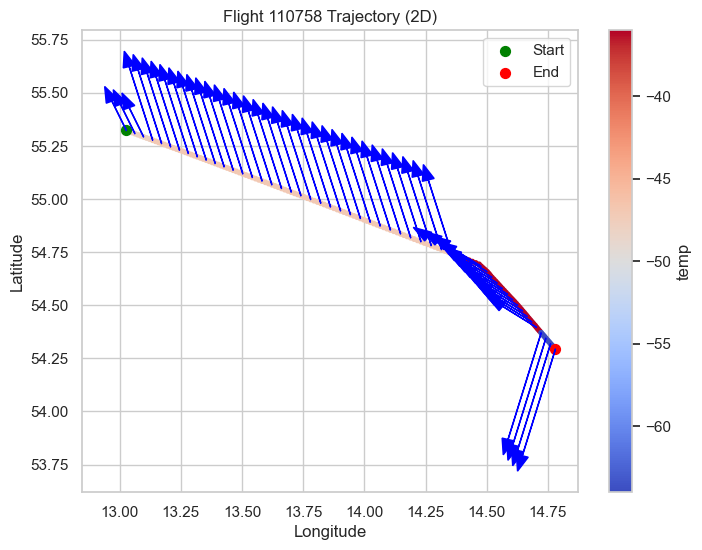

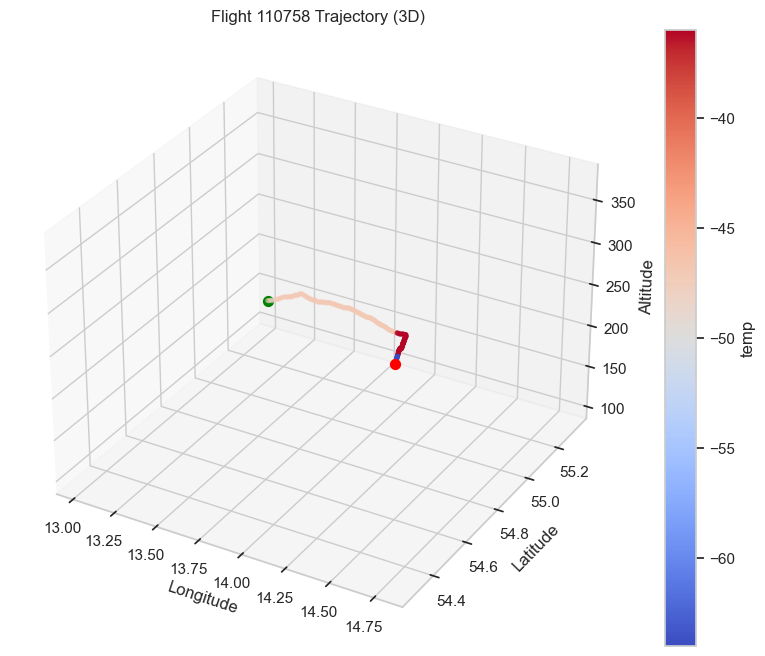

In [56]:
# ex 1: single flight w/ 2D & 3D views, colored by tremp, w/ wind arrows
plot_flight(
    parquet_path= parquet_path,
    flight_id=None,          # random flight
    mode="2D",               
    both=True,              
    color_by="temp",       
    show_wind=True,        
    save=False             
)

Randomly selected flight_id: 1200918


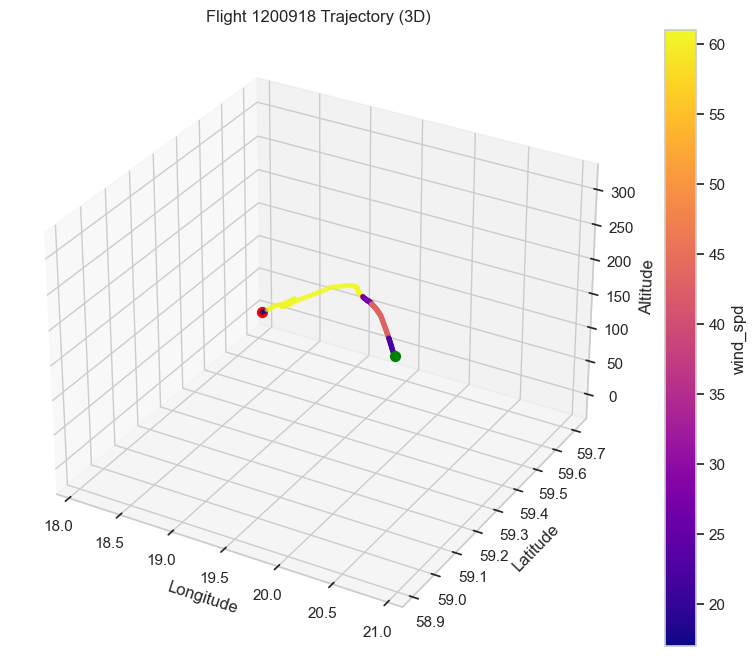

In [57]:
# ex 2: single flight w/ color by wind speed (3D only)
plot_flight(
    parquet_path=parquet_path,
    flight_id=None,
    mode="3D",
    color_by="wind_spd",
    show_wind=False
)

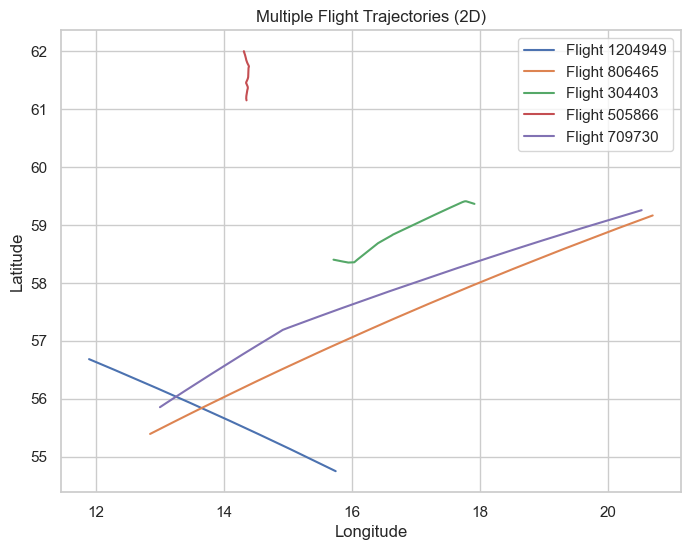

In [58]:
# ex 3: multi-flight (2D)
plot_multiple_flights(
    parquet_path=parquet_path,
    count=5 
)

## Machine Learning

In [5]:
# imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import random
from math import radians, sin, cos, sqrt, atan2

In [6]:
# config
SEQ_LEN = 20
PRED_LEN = 5
BATCH_SIZE = 128
EPOCHS = 50
LR = 0.001
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3
PATIENCE = 10
TEACHER_FORCING_RATIO = 0.5
STRIDE = 10
MAX_SAMPLES = 500_000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [7]:
# feature engineering
def compute_velocity_and_bearing_fast(df):
    # Convert lat/lon to radians
    lat = np.radians(df['lat'].values)
    lon = np.radians(df['lon'].values)

    # Differences
    dlat = np.diff(lat)
    dlon = np.diff(lon)
    R = 6371000  # Earth radius (meters)

    # Haversine distance for velocity
    a = np.sin(dlat/2)**2 + np.cos(lat[:-1]) * np.cos(lat[1:]) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = R * c
    velocities = np.insert(distances, 0, 0.0)  # First row = 0

    # Bearing calculation
    y = np.sin(dlon) * np.cos(lat[1:])
    x = np.cos(lat[:-1]) * np.sin(lat[1:]) - np.sin(lat[:-1]) * np.cos(lat[1:]) * np.cos(dlon)
    bearings = (np.degrees(np.arctan2(y, x)) + 360) % 360
    bearings = np.insert(bearings, 0, 0.0)

    df['velocity'] = velocities
    df['bearing'] = bearings
    return df

# Apply feature engineering
train_df = compute_velocity_and_bearing_fast(train_df)
val_df = compute_velocity_and_bearing_fast(val_df)

# Keep only the required columns
feature_cols = ['lat', 'lon', 'alt', 'velocity', 'bearing']
train_df = train_df[feature_cols].dropna().reset_index(drop=True)
val_df = val_df[feature_cols].dropna().reset_index(drop=True)

# Compute normalization stats
min_vals = train_df.min()
max_vals = train_df.max()
range_vals = max_vals - min_vals
range_vals[range_vals == 0] = 1  # Avoid divide-by-zero

# Normalize
def normalize(df):
    return (df - min_vals) / range_vals

train_df = normalize(train_df)
val_df = normalize(val_df)

# Denormalize for evaluation
def denormalize(arr):
    return arr * range_vals.values + min_vals.values

In [8]:
# datatset + dataloader
class TrajectoryDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, stride=1, max_samples=None):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data = df.values  # NumPy array
        self.samples = []

        # Sliding window sampling
        for i in range(0, len(self.data) - seq_len - pred_len, stride):
            self.samples.append((i, i + seq_len, i + seq_len + pred_len))
            if max_samples and len(self.samples) >= max_samples:
                break

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s, m, e = self.samples[idx]
        past = torch.tensor(self.data[s:m], dtype=torch.float32)
        future = torch.tensor(self.data[m:e], dtype=torch.float32)
        return past, future

# Create datasets
train_dataset = TrajectoryDataset(train_df, SEQ_LEN, PRED_LEN, stride=STRIDE, max_samples=MAX_SAMPLES)
val_dataset = TrajectoryDataset(val_df, SEQ_LEN, PRED_LEN, stride=STRIDE, max_samples=100_000)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Debug sample
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
sample_past, sample_future = train_dataset[0]
print("Sample shapes:", sample_past.shape, sample_future.shape)

Train samples: 500000, Val samples: 100000
Sample shapes: torch.Size([20, 5]) torch.Size([5, 5])


In [9]:
# model 
class Seq2SeqGRU(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=256, num_layers=2, pred_len=5, dropout=0.3):
        super().__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.pred_len = pred_len

    def forward(self, past, future=None, teacher_forcing_ratio=0.5):
        batch_size = past.size(0)
        _, hidden = self.encoder(past)

        decoder_input = past[:, -1:, :]
        outputs = []

        for t in range(self.pred_len):
            out, hidden = self.decoder(decoder_input, hidden)
            pred = self.fc(out.squeeze(1))
            outputs.append(pred)

            if future is not None and random.random() < teacher_forcing_ratio:
                decoder_input = future[:, t:t+1, :]
            else:
                decoder_input = pred.unsqueeze(1)

        return torch.stack(outputs, dim=1)

# model weights
model = Seq2SeqGRU(input_dim=5, hidden_dim=256, num_layers=2, pred_len=5, dropout=0.3).to(DEVICE)
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

In [18]:
# training loop 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()
best_val_loss = float('inf')
wait = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for past, future in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        past, future = past.to(DEVICE), future.to(DEVICE)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            pred = model(past, future, teacher_forcing_ratio=TEACHER_FORCING_RATIO)
            loss = criterion(pred, future)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for past, future in val_loader:
            past, future = past.to(DEVICE), future.to(DEVICE)
            with torch.cuda.amp.autocast():
                pred = model(past, future, teacher_forcing_ratio=0.0)
                val_loss += criterion(pred, future).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

C:\Users\flyin\AppData\Local\Temp\ipykernel_56920\3709673666.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50:   0%|          | 0/3907 [00:00<?, ?it/s]C:\Users\flyin\AppData\Local\Temp\ipykernel_56920\3709673666.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3907/3907 [01:26<00:00, 45.01it/s]
C:\Users\flyin\AppData\Local\Temp\ipykernel_56920\3709673666.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Epoch 1] Train Loss: 0.001680 | Val Loss: 0.001608


Epoch 2/50: 100%|██████████| 3907/3907 [01:24<00:00, 46.33it/s]


[Epoch 2] Train Loss: 0.001108 | Val Loss: 0.001547


Epoch 3/50: 100%|██████████| 3907/3907 [01:23<00:00, 46.93it/s]


[Epoch 3] Train Loss: 0.001039 | Val Loss: 0.001503


Epoch 4/50: 100%|██████████| 3907/3907 [01:23<00:00, 46.57it/s]


[Epoch 4] Train Loss: 0.000979 | Val Loss: 0.001450


Epoch 5/50: 100%|██████████| 3907/3907 [01:23<00:00, 47.07it/s]


[Epoch 5] Train Loss: 0.000956 | Val Loss: 0.001427


Epoch 6/50: 100%|██████████| 3907/3907 [01:26<00:00, 45.14it/s]


[Epoch 6] Train Loss: 0.000945 | Val Loss: 0.001421


Epoch 7/50: 100%|██████████| 3907/3907 [01:24<00:00, 46.34it/s]


[Epoch 7] Train Loss: 0.000932 | Val Loss: 0.001411


Epoch 8/50: 100%|██████████| 3907/3907 [01:21<00:00, 48.00it/s]


[Epoch 8] Train Loss: 0.000926 | Val Loss: 0.001390


Epoch 9/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.25it/s]


[Epoch 9] Train Loss: 0.000918 | Val Loss: 0.001378


Epoch 10/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.28it/s]


[Epoch 10] Train Loss: 0.000910 | Val Loss: 0.001392


Epoch 11/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.30it/s]


[Epoch 11] Train Loss: 0.000901 | Val Loss: 0.001406


Epoch 12/50: 100%|██████████| 3907/3907 [01:21<00:00, 48.22it/s]


[Epoch 12] Train Loss: 0.000900 | Val Loss: 0.001376


Epoch 13/50: 100%|██████████| 3907/3907 [01:19<00:00, 48.94it/s]


[Epoch 13] Train Loss: 0.000903 | Val Loss: 0.001378


Epoch 14/50: 100%|██████████| 3907/3907 [01:19<00:00, 49.12it/s]


[Epoch 14] Train Loss: 0.000897 | Val Loss: 0.001387


Epoch 15/50: 100%|██████████| 3907/3907 [01:19<00:00, 49.22it/s]


[Epoch 15] Train Loss: 0.000886 | Val Loss: 0.001385


Epoch 16/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.37it/s]


[Epoch 16] Train Loss: 0.000888 | Val Loss: 0.001391


Epoch 17/50: 100%|██████████| 3907/3907 [01:19<00:00, 49.31it/s]


[Epoch 17] Train Loss: 0.000881 | Val Loss: 0.001374


Epoch 18/50: 100%|██████████| 3907/3907 [01:19<00:00, 49.45it/s]


[Epoch 18] Train Loss: 0.000879 | Val Loss: 0.001364


Epoch 19/50: 100%|██████████| 3907/3907 [01:21<00:00, 48.10it/s]


[Epoch 19] Train Loss: 0.000871 | Val Loss: 0.001435


Epoch 20/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.54it/s]


[Epoch 20] Train Loss: 0.000879 | Val Loss: 0.001356


Epoch 21/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.77it/s]


[Epoch 21] Train Loss: 0.000866 | Val Loss: 0.001401


Epoch 22/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.50it/s]


[Epoch 22] Train Loss: 0.000869 | Val Loss: 0.001361


Epoch 23/50: 100%|██████████| 3907/3907 [01:19<00:00, 48.97it/s]


[Epoch 23] Train Loss: 0.000872 | Val Loss: 0.001425


Epoch 24/50: 100%|██████████| 3907/3907 [01:21<00:00, 47.78it/s]


[Epoch 24] Train Loss: 0.000865 | Val Loss: 0.001407


Epoch 25/50: 100%|██████████| 3907/3907 [01:21<00:00, 48.13it/s]


[Epoch 25] Train Loss: 0.000859 | Val Loss: 0.001376


Epoch 26/50: 100%|██████████| 3907/3907 [01:15<00:00, 51.79it/s]


[Epoch 26] Train Loss: 0.000853 | Val Loss: 0.001388


Epoch 27/50: 100%|██████████| 3907/3907 [01:29<00:00, 43.55it/s]


[Epoch 27] Train Loss: 0.000845 | Val Loss: 0.001350


Epoch 28/50: 100%|██████████| 3907/3907 [01:21<00:00, 48.13it/s]


[Epoch 28] Train Loss: 0.000847 | Val Loss: 0.001356


Epoch 29/50: 100%|██████████| 3907/3907 [01:19<00:00, 49.25it/s]


[Epoch 29] Train Loss: 0.000838 | Val Loss: 0.001392


Epoch 30/50: 100%|██████████| 3907/3907 [01:22<00:00, 47.30it/s]


[Epoch 30] Train Loss: 0.000843 | Val Loss: 0.001370


Epoch 31/50: 100%|██████████| 3907/3907 [01:20<00:00, 48.72it/s]


[Epoch 31] Train Loss: 0.000839 | Val Loss: 0.001366


Epoch 32/50: 100%|██████████| 3907/3907 [01:17<00:00, 50.40it/s]


[Epoch 32] Train Loss: 0.000838 | Val Loss: 0.001398


Epoch 33/50: 100%|██████████| 3907/3907 [01:17<00:00, 50.21it/s]


[Epoch 33] Train Loss: 0.000838 | Val Loss: 0.001428


Epoch 34/50: 100%|██████████| 3907/3907 [01:17<00:00, 50.18it/s]


[Epoch 34] Train Loss: 0.000836 | Val Loss: 0.001476


Epoch 35/50: 100%|██████████| 3907/3907 [01:16<00:00, 50.77it/s]


[Epoch 35] Train Loss: 0.000836 | Val Loss: 0.001402


Epoch 36/50: 100%|██████████| 3907/3907 [01:17<00:00, 50.54it/s]


[Epoch 36] Train Loss: 0.000827 | Val Loss: 0.001484


Epoch 37/50: 100%|██████████| 3907/3907 [01:18<00:00, 49.77it/s]


[Epoch 37] Train Loss: 0.000835 | Val Loss: 0.001455
Early stopping triggered.


C:\Users\flyin\AppData\Local\Temp\ipykernel_48336\2105191518.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


MAE Horizontal: 4409.48 m
RMSE Horizontal: 4541.09 m
MAE Altitude: 3.33 m
RMSE Altitude: 4.12 m


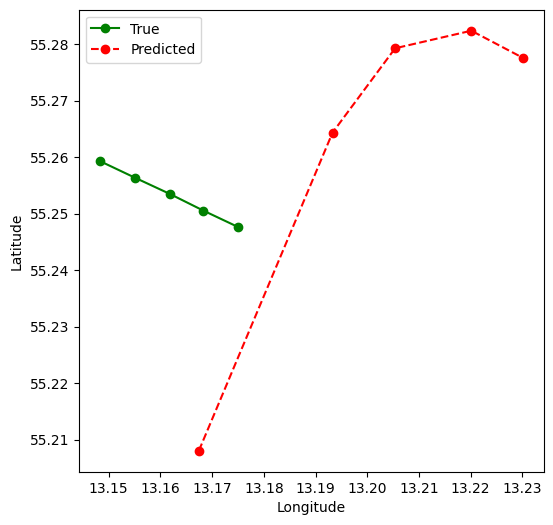

In [10]:
# # evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

with torch.no_grad():
    past, future = next(iter(val_loader))
    past, future = past.to(DEVICE), future.to(DEVICE)
    pred = model(past, teacher_forcing_ratio=0.0)

    pred_np = pred[0].cpu().numpy()
    true_np = future[0].cpu().numpy()

    pred_real = denormalize(pred_np)
    true_real = denormalize(true_np)

    # Metrics
    distances = [haversine_distance(true_real[i][0], true_real[i][1], pred_real[i][0], pred_real[i][1]) for i in range(len(pred_real))]
    alt_diffs = [abs(true_real[i][2] - pred_real[i][2]) for i in range(len(pred_real))]

    print(f"MAE Horizontal: {np.mean(distances):.2f} m")
    print(f"RMSE Horizontal: {np.sqrt(np.mean(np.array(distances)**2)):.2f} m")
    print(f"MAE Altitude: {np.mean(alt_diffs):.2f} m")
    print(f"RMSE Altitude: {np.sqrt(np.mean(np.array(alt_diffs)**2)):.2f} m")

    # Plots
    plt.figure(figsize=(6,6))
    plt.plot(true_real[:, 1], true_real[:, 0], 'g-o', label='True')
    plt.plot(pred_real[:, 1], pred_real[:, 0], 'r--o', label='Predicted')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()